In [1]:
import json
import requests
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

from matplotlib import pyplot as plt

In [58]:
def sin_func(x, a, b):
    d = 0.000000001
    return a + b * np.sin(x * d)


def line_func(x, a, b):
    return a * x + b


def get_data(trade_code):
    base_url = "http://iss.moex.com/iss/history/engines/stock/markets/shares/boards/TQBR/securities.json"
    response = requests.get(base_url)
    result = json.loads(response.text)
    col_name = result['history']['columns']
    data_shares = pd.DataFrame(columns=col_name)

    url_share = f'http://iss.moex.com/iss/history/engines/stock/markets/shares/boards/TQBR/securities/{trade_code}.json'
    response = requests.get(url_share)
    result = json.loads(response.text)
    resp_date = result['history']['data']
    data_shares = pd.DataFrame(resp_date, columns=col_name)
    a = len(resp_date)

    b = 100
    while a == 100:
        url_opt = '?start=' + str(b)
        url_next_page = url_share + url_opt
        response = requests.get(url_next_page)
        result = json.loads(response.text)
        resp_date = result['history']['data']
        data_next_page = pd.DataFrame(resp_date, columns=col_name)
        data_shares = pd.concat([data_shares, data_next_page], ignore_index=True)
        a = len(resp_date)
        b = b + 100
    return data_shares


def show_plot(x1, y1, label_1, x2, y2, label_2, x3, y3, label_3):
    fig = plt.Figure(figsize=(7, 5))
#     plt.plot(x1, y1, label=label_1)
    plt.plot(x2, y2, label=label_2)
    plt.plot(x3, y3, label=label_3)
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Open')
    plt.xticks(rotation=45)


def line_sin_predict(size, x, y, x_data, w, curve_type='line'):
    # return 1 if func is increasing and 0 if func is decreasing
    x = x[:-700]
    x_data = x_data[:-700]
    y = y[:-700]
    if size != 0:
        size += w
    x_sized = x[-size:-w]
    y_sized = y[-size:-w]
    x_full = x[-size:]
    y_full = y[-size:]
    x_data_sized = x_data[-size:-w]
    x_data_full = x_data[-size:]
    
    if curve_type == 'line':
        params, cov = curve_fit(line_func, x_sized, y_sized)
        y_predict = [line_func(x_sized[i], *params) for i in range(len(x_sized))]
    else:
        params, cov = curve_fit(sin_func, x_sized, y_sized)
        y_predict = [sin_func(x_sized[i], *params) for i in range(len(x_sized))]
    show_plot(x_sized, y_sized, 'origin', x_data_sized, y_predict, 'predict', x_data_full, y_full, 'historical data')
    if y_predict[-1] > y_predict[-2]:
        return 1
    else:
        return 0


def get_prediction(trade_code, mode_type):
    data_shares = get_data(trade_code)
    if len(data_shares) == 0:
        return 2
    time_and_open_df = data_shares[['TRADEDATE', 'OPEN']]
    time_and_open_df = time_and_open_df.dropna()
    time_and_open_df['TRADEDATE'] = time_and_open_df['TRADEDATE'].astype("datetime64[ns]")
    x_data = time_and_open_df['TRADEDATE'].to_list()
    time_and_open_df['TRADEDATE'] = time_and_open_df['TRADEDATE'].values.astype("float64")

    x = time_and_open_df['TRADEDATE'].to_list()
    y = time_and_open_df['OPEN'].to_list()
    if mode_type == 0:
        num = 10
        curve_type = 'line'
        w = 30
    elif mode_type == 1:
        num = 40
        curve_type = 'sin'
        w = 20
    else:
        num = 0
        curve_type = 'line'
        w = 600
    predict = line_sin_predict(num, x, y, x_data, w, curve_type=curve_type)
    return predict

/tmp/ipykernel_81130/4095965391.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_shares = pd.concat([data_shares, data_next_page], ignore_index=True)


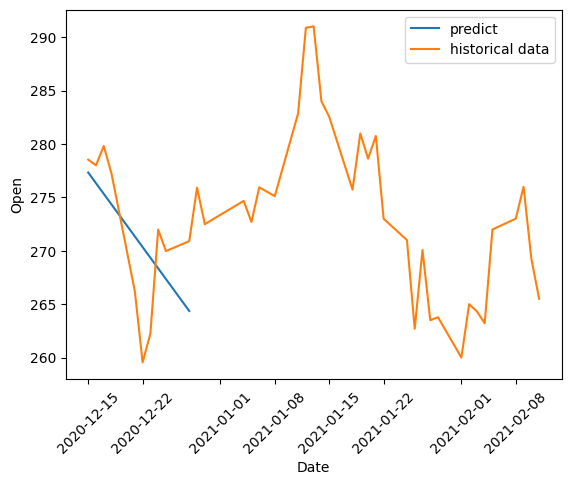

In [55]:
predict = get_prediction("SBER", 0)

/tmp/ipykernel_81130/4095965391.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_shares = pd.concat([data_shares, data_next_page], ignore_index=True)
/tmp/ipykernel_81130/4095965391.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_shares = pd.concat([data_shares, data_next_page], ignore_index=True)


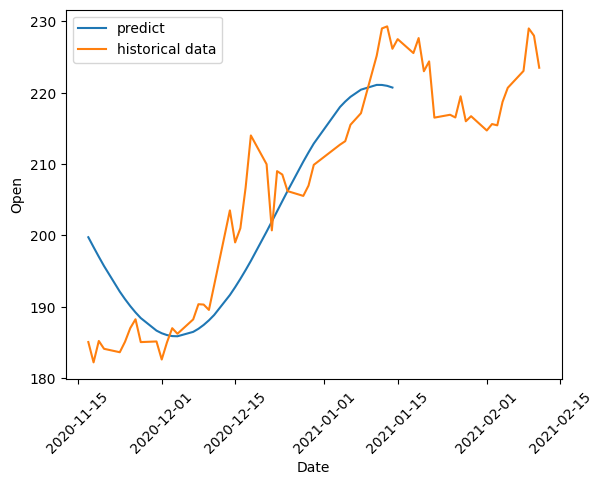

In [56]:
predict = get_prediction("GAZP", 1)

/tmp/ipykernel_81130/1599858875.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_shares = pd.concat([data_shares, data_next_page], ignore_index=True)


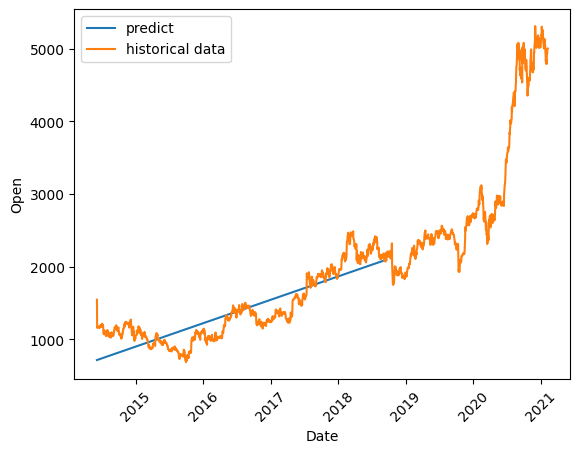

In [59]:
predict = get_prediction("YNDX", 2)